demo : Reuters newswire topics (Keras dataset)

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
from feature_eng import WordAndDoc2vec

In [3]:
import os.path
import sys
import re
import itertools
import csv
import datetime
import pickle
import random
from collections import defaultdict, Counter
import gc

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import gensim
from sklearn.metrics import f1_score, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
import gensim
from keras.preprocessing.sequence import skipgrams
import tensorflow as tf

In [4]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, cmap=cmap, **kwargs)
def scatter(x, y, color, **kwargs):
    plt.scatter(x, y, marker='.')

### create sample data

In [5]:
from keras.datasets import reuters

In [6]:
word_index = reuters.get_word_index()
word_index2 = dict([(k, v+3) for k, v in word_index.items()])
word_dic = gensim.corpora.Dictionary([['<padding>', '<start_char>', '<oov_char>'],], prune_at=None)
word_dic.token2id.update(word_index2)

In [7]:
word_dic[27595]

'mcgrath'

In [8]:
word_dic[4]

'the'

In [9]:
(doc, cat), (doc_test, cat_test) = reuters.load_data(test_split=0.0, start_char=None)

In [10]:
' '.join([word_dic[ee] for ee in doc[0]])

'mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [11]:
doc_dic = gensim.corpora.Dictionary(prune_at=None)
doc_dic.token2id.update(dict([('d'+str(ee+1), ee) for ee in range(len(doc))]))

In [12]:
doc_seq = [[word_dic[ee] for ee in doc[ii]] for ii in range(len(doc))]

In [13]:
cat
cls = pd.Series(['c'+str(c) for c in cat])

### create WordAndDoc2vec instance

In [14]:
wd2v = WordAndDoc2vec(doc_seq, word_dic, doc_dic, logging=False)
wd2v

len(doc_seq) >>> 11228
max(doc_dic.keys()) + 1 >>> 11228
num_features >>> 30983
corpus_csr.shape >>> (11228, 30983)
creating tfidf...


In [15]:
num_features = 96
wd2v.make_model(max_num_prod=5, num_neg=3, num_features=num_features,
                embeddings_val=0.5, gamma=0.0)

{'model': <keras.engine.training.Model at 0x7f7925d64e48>,
 'model_neg': <keras.engine.training.Model at 0x7f79266d7470>,
 'model_prob0': <keras.engine.training.Model at 0x7f7926552e10>,
 'model_prob2': <keras.engine.training.Model at 0x7f79267527b8>,
 'model_prod': <keras.engine.training.Model at 0x7f79266d5cf8>,
 'model_user': <keras.engine.training.Model at 0x7f79254eb9b0>}

(30983, 96)


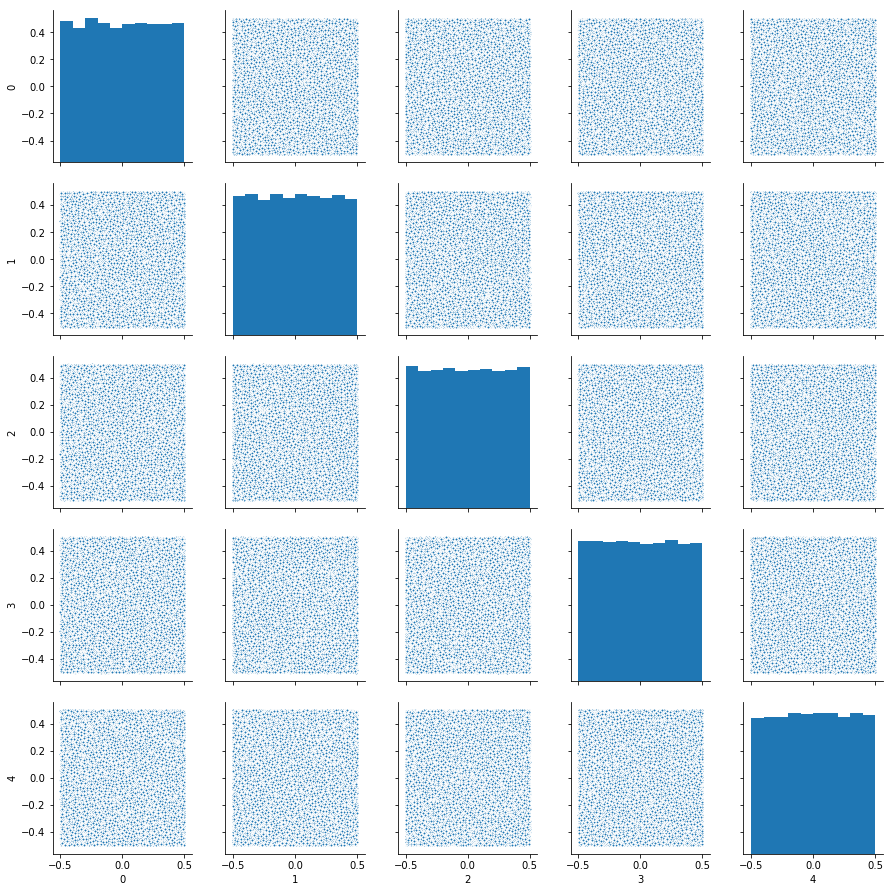

In [16]:
wgt_prod = wd2v.wgt_col
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
sns.pairplot(df, markers='.')

(11228, 96)


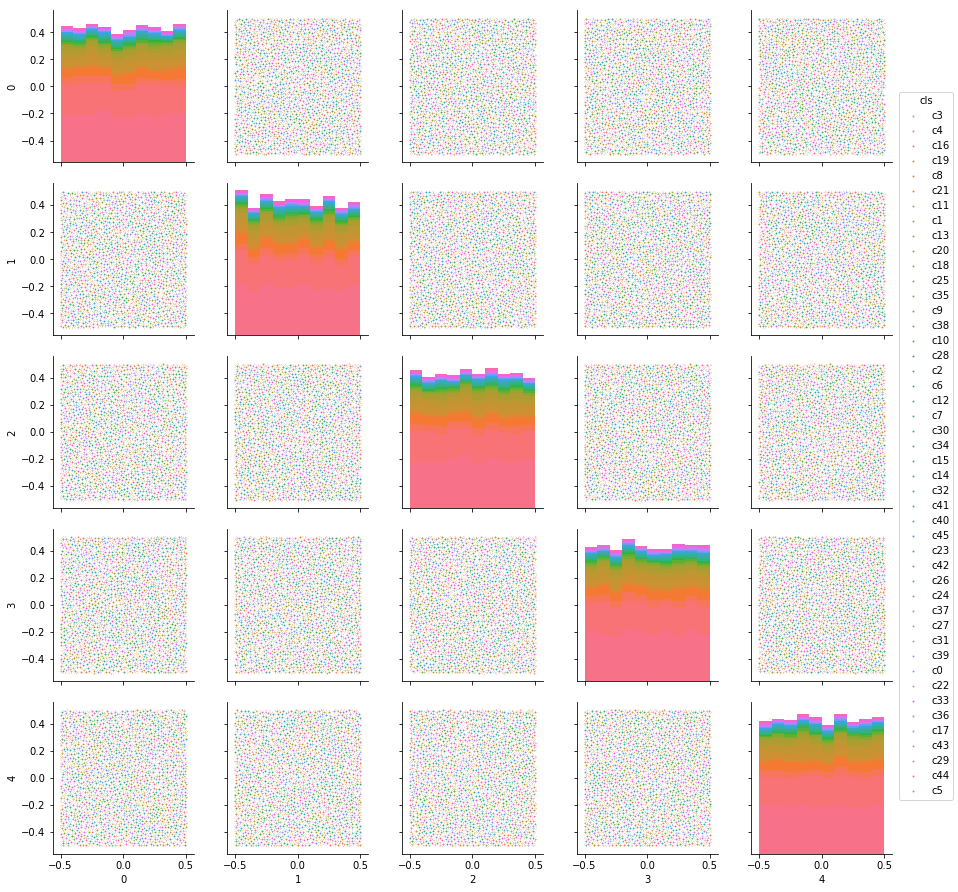

In [17]:
wgt_user = wd2v.wgt_row
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
df['cls'] = cls.tolist()
sns.pairplot(df, markers='.', hue='cls')

### start train
note : it will take a long time...

In [18]:
wd2v.train(epochs=250, verbose=0)

len(seq) >>> 351


/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### get feature vectors

(30983, 96)


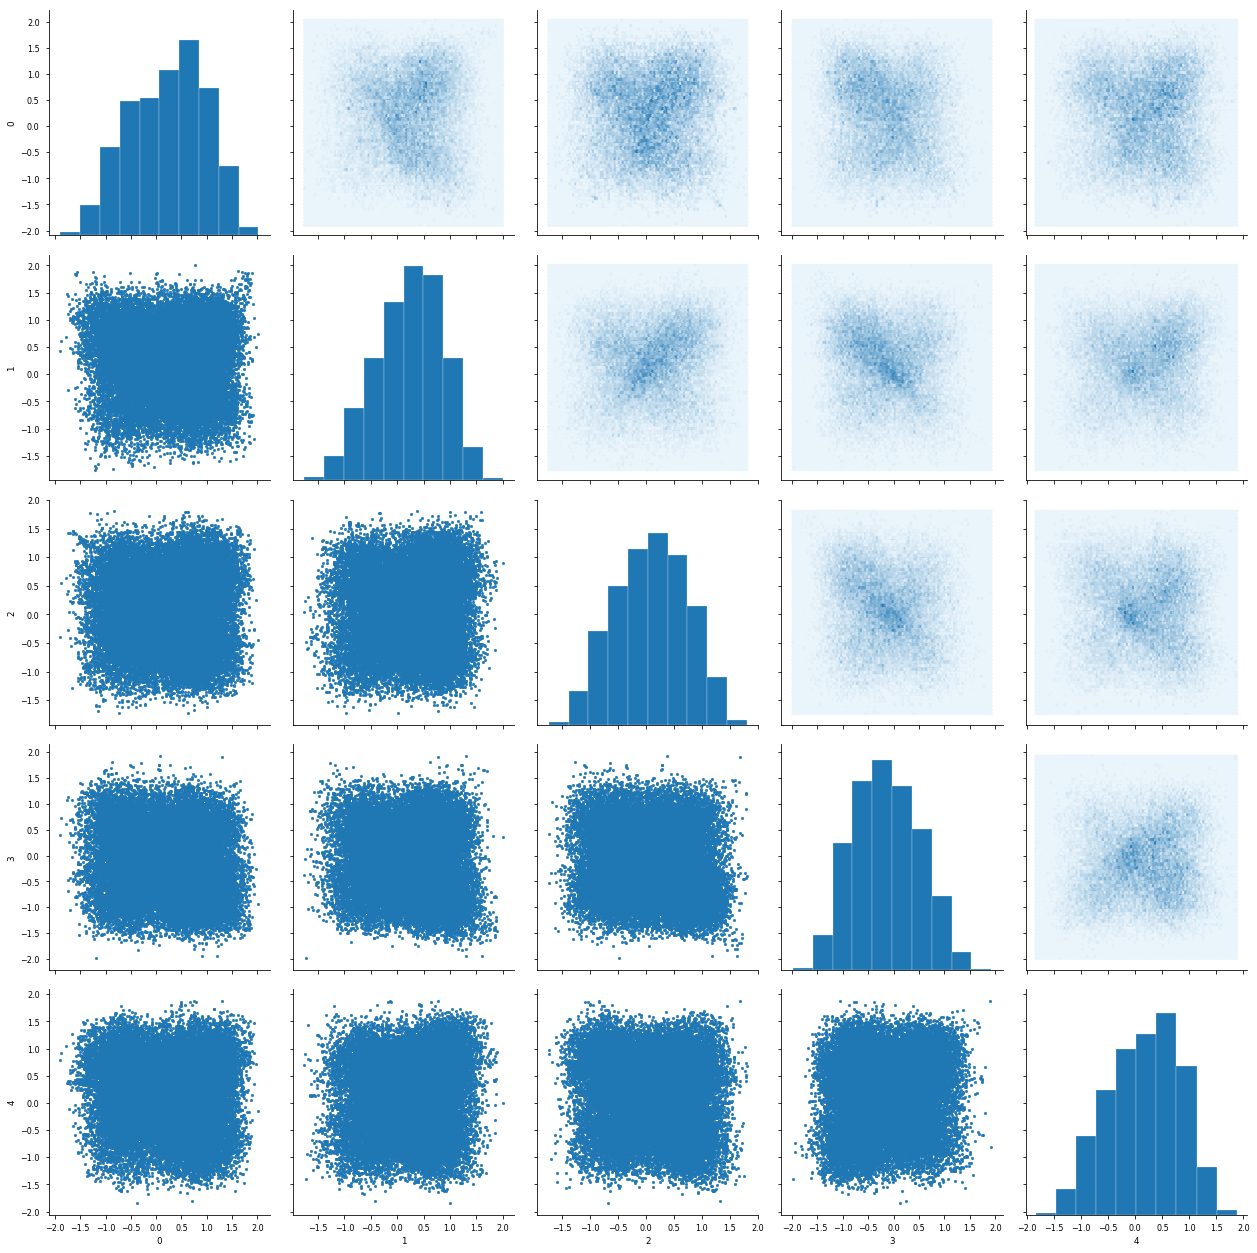

In [19]:
wgt_prod = wd2v.wgt_col
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(11228, 96)


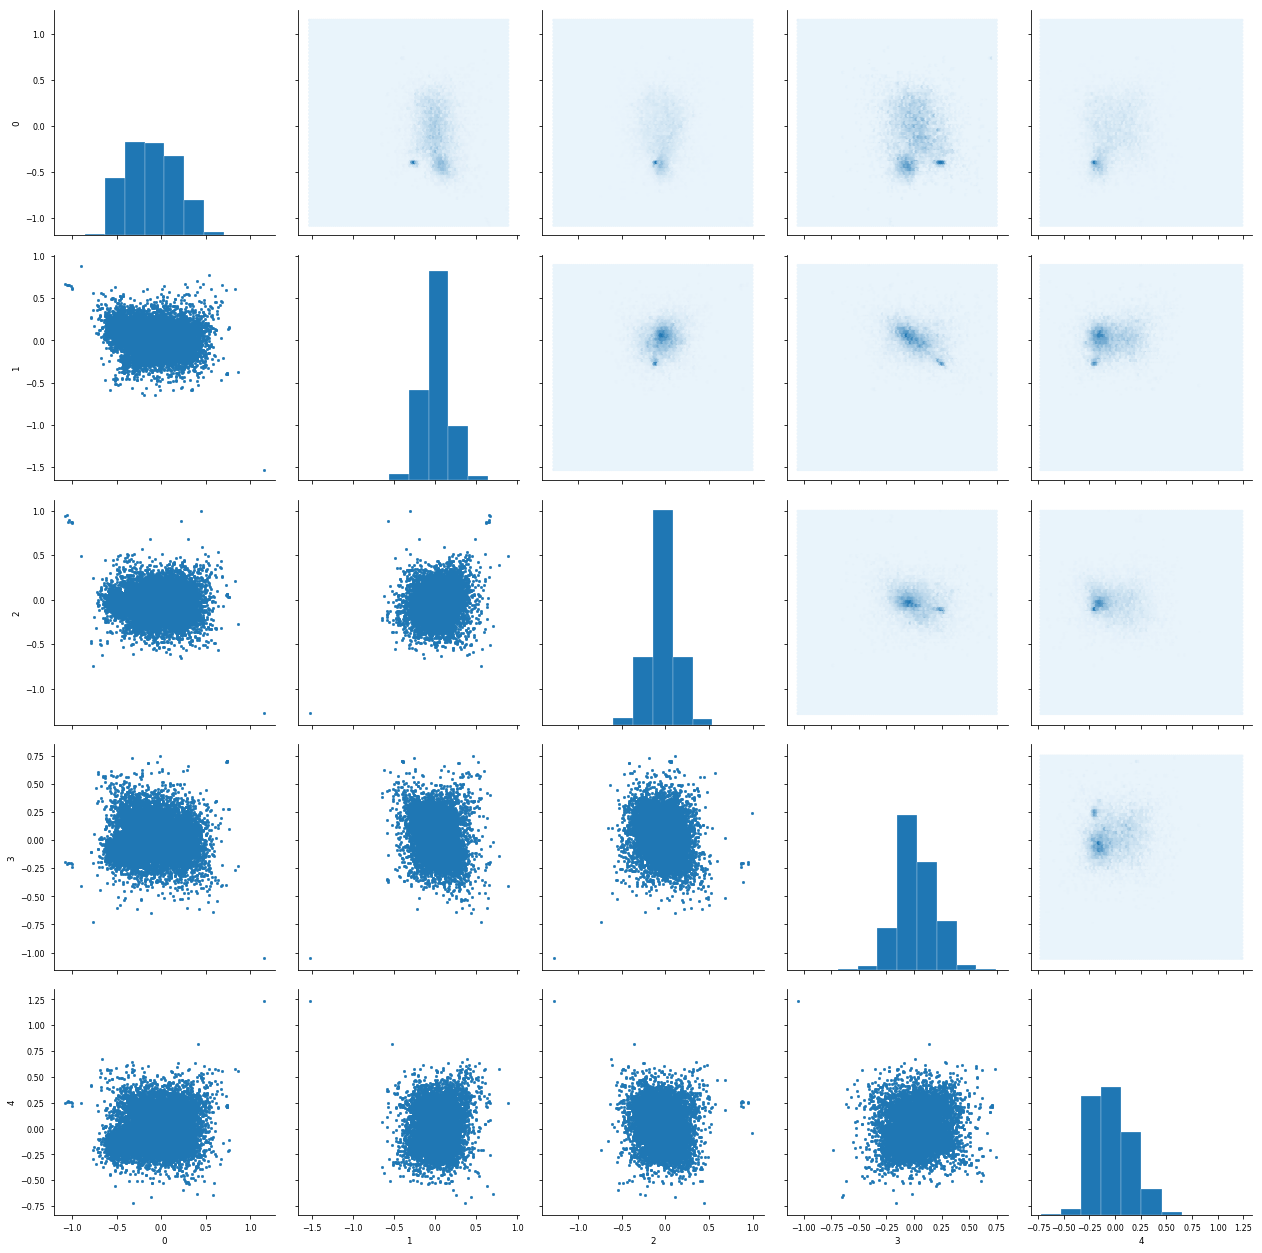

In [20]:
wgt_user = wd2v.wgt_row
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(11228, 96)


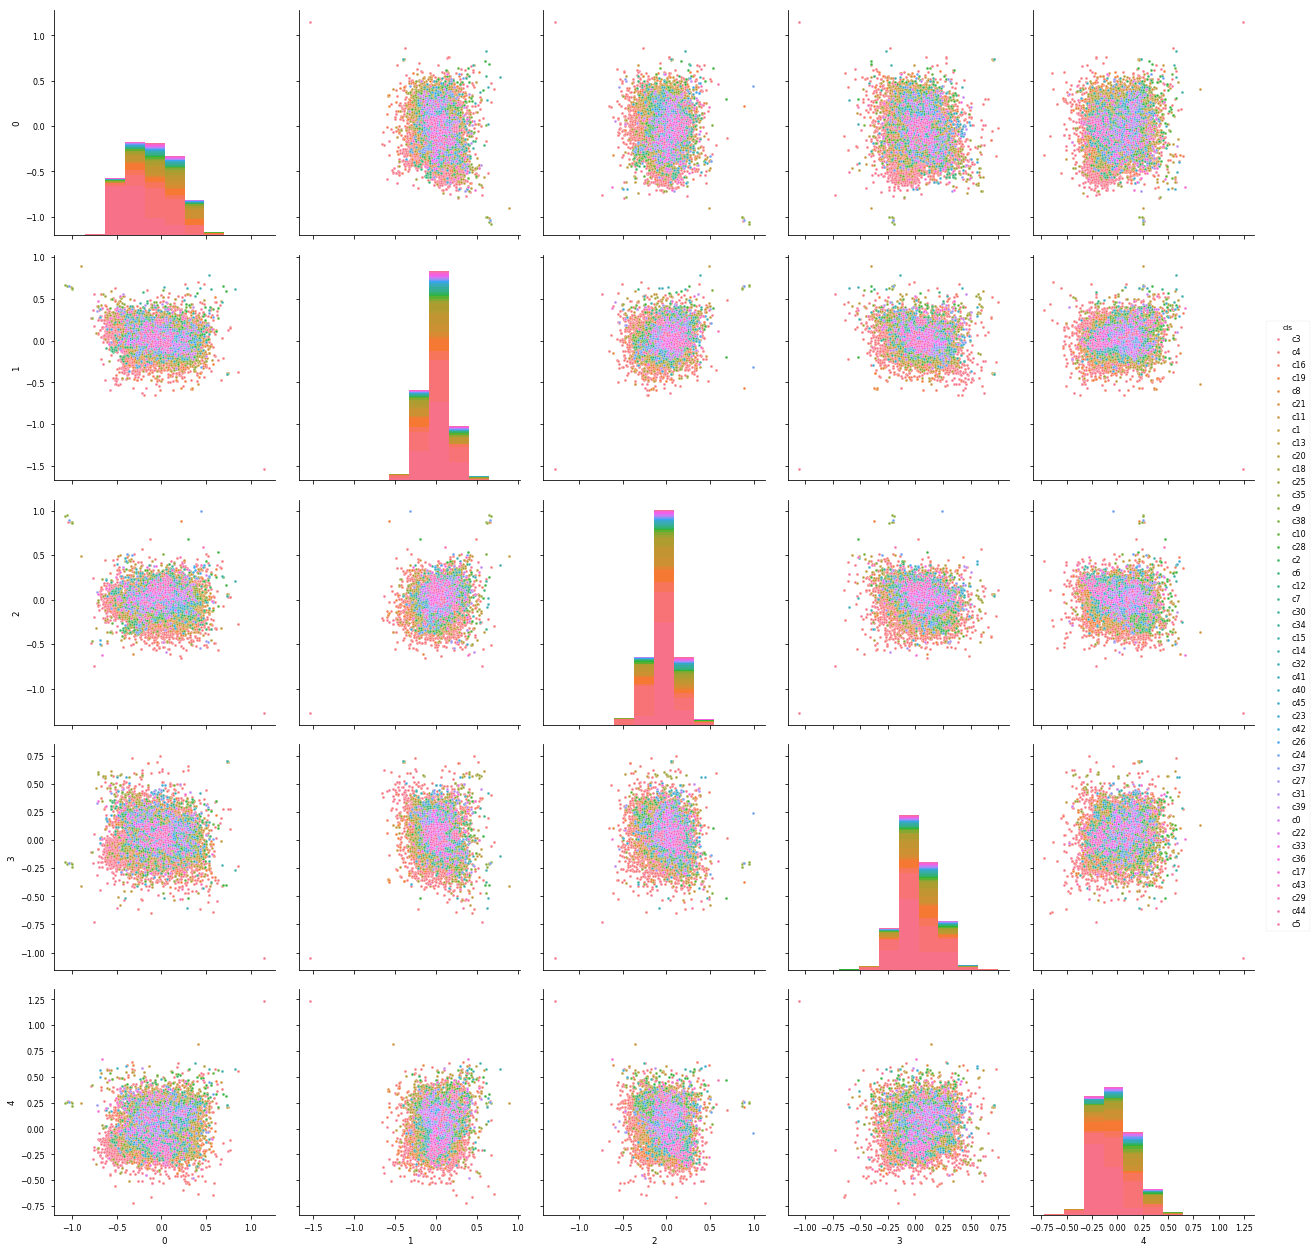

In [21]:
wgt_user = wd2v.wgt_row
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
df['cls'] = cls.tolist()
sns.pairplot(df, markers='.', hue='cls', size=3.5)

### similarity

In [22]:
sim = wd2v.sim
print(sim.num_features)
print(sim.sim_row)

96
MatrixSimilarity<11228 docs, 96 features>


In [23]:
query = sim.sim_row.index[sim.row_dic.token2id['d1']]
query

array([ 0.02497981,  0.0636895 ,  0.01400545, -0.06982963, -0.14548557,
        0.02404452,  0.14836738, -0.14174142,  0.04971446,  0.1045197 ,
       -0.06893741, -0.15446326,  0.08345449, -0.03717267,  0.13715713,
        0.01225504, -0.04845567,  0.01941785,  0.11970529, -0.07044456,
       -0.05165668,  0.04959868, -0.10075609,  0.23351717, -0.04854463,
        0.06625798,  0.12574485, -0.02745426,  0.09256847,  0.01445879,
       -0.00821022, -0.05779212, -0.01223264,  0.04853483,  0.04118649,
       -0.06305161, -0.14606853, -0.19036703,  0.11635163, -0.03822401,
       -0.10511305,  0.00754026, -0.13946982, -0.04787624,  0.16488516,
        0.02517979, -0.03168642,  0.05505396, -0.1115237 ,  0.15047173,
        0.13832834,  0.0244363 ,  0.17026371,  0.09823735, -0.07212296,
       -0.13690351,  0.21892919, -0.01278855, -0.00781997, -0.07285003,
        0.09033459, -0.04838499, -0.15016401,  0.06284187, -0.09863777,
        0.02874852, -0.12437432, -0.02069139, -0.04212529, -0.13

In [24]:
sim.get_sim_bycol(query, num_best=10)

[('rentcorp', 0.8671900033950806),
 ('mcgrath', 0.8574903011322021),
 ('earnings', 0.7785316705703735),
 ('dlrs', 0.7550715804100037),
 ('operations', 0.7502057552337646),
 ('assets', 0.7486269474029541),
 ('name', 0.7396586537361145),
 ('operating', 0.7393564581871033),
 ('mth', 0.7358484864234924),
 ('gain', 0.7356608510017395)]

In [25]:
sim.get_sim_byrow(query, num_best=10)

[('d1', 1.0),
 ('d7985', 0.793116569519043),
 ('d9302', 0.7694904208183289),
 ('d7576', 0.7682617902755737),
 ('d3083', 0.7650549411773682),
 ('d2179', 0.7619441747665405),
 ('d9165', 0.7600363492965698),
 ('d4589', 0.7595535516738892),
 ('d3341', 0.7567096948623657),
 ('d7600', 0.7560499310493469)]